In [2]:
import os
import sys
sys.path.append('../..')
import numpy as np
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple

from joblib import Parallel, delayed
import subprocess
from statistics import mode
import json

In [3]:
def display_number(X,SCALE):
    X = X.reshape(SCALE[0],SCALE[1],3)
    plt.imshow(X,cmap='gray')
    plt.show()
    
def display_explanation(x0,SCALE,expl):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    x0_2d = x0.reshape(SCALE[0],SCALE[1],3)
    ax1.set_title('Input')
    ax1.imshow(x0_2d,cmap='gray')
    expl_2d = expl.reshape(SCALE[0],SCALE[1],3)
    ax2.set_title('Explanation')
    ax2.imshow(expl_2d)
    
    cmap = plt.cm.gray
    norm = plt.Normalize(x0.min(),x0.max())
    rgba = cmap(norm(x0))
    
    norm_ex = plt.Normalize(expl.min(),expl.max())
    normed_ex = norm_ex(expl)
    
    for i,x in enumerate(normed_ex):
        if x > 0:
            rgba[i] = x,0,0,1
    
    rgba = rgba.reshape(SCALE[0],SCALE[1],4)
    
    ax3.set_title('Overlayed')
    ax3.imshow(rgba,interpolation='nearest')
    plt.show()

In [4]:
# Load mnist data and scale down to SCALE (trying 14x14 initially)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
SCALE = (14,14)
if not SCALE == X_train[0].shape:
    X_train = np.array(list(map(lambda x:cv2.resize(x,SCALE,interpolation=cv2.INTER_CUBIC),X_train)))
X_train = np.array(list(map(lambda x:cv2.cvtColor(x,cv2.COLOR_GRAY2RGB),X_train)))
X_train = X_train/255.
X_train = X_train.astype("float32").reshape(len(X_train), SCALE[0],SCALE[1],3)

if not SCALE == X_test.shape:
    X_test = np.array(list(map(lambda x:cv2.resize(x,SCALE,interpolation=cv2.INTER_CUBIC),X_test)))
X_test = np.array(list(map(lambda x:cv2.cvtColor(x,cv2.COLOR_GRAY2RGB),X_test)))
X_test = X_test/255.
X_test = X_test.astype("float32").reshape(len(X_test), SCALE[0], SCALE[1],3)

# make it a binary classification task (X or not X)
target = 8
y_train = np.array([1 if y == target else 0 for y in y_train])
y_test = np.array([1 if y == target else 0 for y in y_test])

# filter so we get about 50% target class and 50% other
target_idxs = [i for i in range(len(y_train)) if y_train[i] == 1]
other_idxs = [i for i in range(len(y_train)) if y_train[i] == 0]

#uncomment the shuffle for training only
#random.shuffle(other_idxs)
other_idxs = other_idxs[:len(target_idxs)]
# pick len(target_idxs) samples from the other_idxs
X_train = np.array([x for i,x in enumerate(X_train) if i in other_idxs or i in target_idxs])
y_train = np.array([y for i,y in enumerate(y_train) if i in other_idxs or i in target_idxs])

(28, 28)


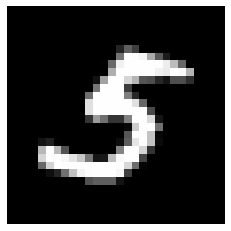

In [8]:
#plt.imshow(X_train[0])
print(X_train[0].shape)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
n = np.random.choice(len(X_train))
plt.imshow(X_train[n],cmap='gray')
plt.axis('off')
plt.show()

In [90]:
model_name = f'mnist{SCALE[0]}x{SCALE[1]}_32_16_binary_target{target}_coverage_rgb'
opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()

inputs = Input(shape=X_train[0].shape)
tmp = Flatten()(inputs)
tmp = Dense(256,activation='relu')(tmp)
tmp = Dense(128,activation='relu')(tmp)
predictions = Dense(2,activation='softmax')(tmp)
model = Model(inputs=inputs,outputs=predictions)

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

  2%|▏         | 4/183 [00:00<00:04, 36.64it/s]

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(588, 256) 0.05832118435198043
(256, 128) 0.08838834764831845
(128, 2) 0.125
deepbayes: Using implicit prior
(588, 256) 0.05832118435198043
(256, 128) 0.08838834764831845
(128, 2) 0.125


  3%|▎         | 6/183 [00:00<00:03, 56.96it/s]

Epoch 1, loss: 0.493, acc: 0.751, val_loss: 0.314, val_acc: 0.868


  3%|▎         | 5/183 [00:00<00:03, 48.00it/s]

Epoch 2, loss: 0.339, acc: 0.870, val_loss: 0.695, val_acc: 0.701


  3%|▎         | 5/183 [00:00<00:03, 45.64it/s]

Epoch 3, loss: 0.254, acc: 0.897, val_loss: 0.161, val_acc: 0.935


  3%|▎         | 6/183 [00:00<00:03, 50.22it/s]

Epoch 4, loss: 0.210, acc: 0.920, val_loss: 0.274, val_acc: 0.894


  3%|▎         | 6/183 [00:00<00:03, 58.43it/s]

Epoch 5, loss: 0.179, acc: 0.931, val_loss: 0.208, val_acc: 0.928


  3%|▎         | 6/183 [00:00<00:03, 52.94it/s]

Epoch 6, loss: 0.157, acc: 0.941, val_loss: 0.121, val_acc: 0.960


  3%|▎         | 6/183 [00:00<00:03, 57.33it/s]

Epoch 7, loss: 0.128, acc: 0.952, val_loss: 0.072, val_acc: 0.978


  3%|▎         | 6/183 [00:00<00:03, 55.45it/s]

Epoch 8, loss: 0.106, acc: 0.960, val_loss: 0.070, val_acc: 0.977


  3%|▎         | 6/183 [00:00<00:03, 57.86it/s]

Epoch 9, loss: 0.098, acc: 0.963, val_loss: 0.143, val_acc: 0.955


  3%|▎         | 6/183 [00:00<00:03, 52.03it/s]

Epoch 10, loss: 0.076, acc: 0.972, val_loss: 0.100, val_acc: 0.967


  3%|▎         | 6/183 [00:00<00:03, 57.45it/s]

Epoch 11, loss: 0.068, acc: 0.976, val_loss: 0.056, val_acc: 0.982


  3%|▎         | 6/183 [00:00<00:03, 53.24it/s]

Epoch 12, loss: 0.058, acc: 0.979, val_loss: 0.096, val_acc: 0.969


  3%|▎         | 5/183 [00:00<00:03, 46.45it/s]

Epoch 13, loss: 0.051, acc: 0.982, val_loss: 0.072, val_acc: 0.979


  3%|▎         | 6/183 [00:00<00:03, 57.59it/s]

Epoch 14, loss: 0.045, acc: 0.983, val_loss: 0.067, val_acc: 0.980


  3%|▎         | 6/183 [00:00<00:02, 59.14it/s]

Epoch 15, loss: 0.041, acc: 0.986, val_loss: 0.089, val_acc: 0.974


  3%|▎         | 6/183 [00:00<00:03, 57.16it/s]

Epoch 16, loss: 0.037, acc: 0.987, val_loss: 0.057, val_acc: 0.984


  3%|▎         | 6/183 [00:00<00:03, 58.32it/s]

Epoch 17, loss: 0.034, acc: 0.988, val_loss: 0.080, val_acc: 0.976


  3%|▎         | 5/183 [00:00<00:03, 49.55it/s]

Epoch 18, loss: 0.030, acc: 0.989, val_loss: 0.068, val_acc: 0.980


  3%|▎         | 6/183 [00:00<00:03, 54.00it/s]

Epoch 19, loss: 0.026, acc: 0.991, val_loss: 0.062, val_acc: 0.983


  3%|▎         | 6/183 [00:00<00:03, 55.96it/s]

Epoch 20, loss: 0.022, acc: 0.992, val_loss: 0.073, val_acc: 0.981


  3%|▎         | 5/183 [00:00<00:04, 41.68it/s]

Epoch 21, loss: 0.019, acc: 0.993, val_loss: 0.061, val_acc: 0.984


  3%|▎         | 6/183 [00:00<00:03, 56.27it/s]

Epoch 22, loss: 0.017, acc: 0.994, val_loss: 0.082, val_acc: 0.980


  3%|▎         | 5/183 [00:00<00:03, 48.86it/s]

Epoch 23, loss: 0.016, acc: 0.994, val_loss: 0.060, val_acc: 0.985


  3%|▎         | 6/183 [00:00<00:03, 57.30it/s]

Epoch 24, loss: 0.014, acc: 0.994, val_loss: 0.083, val_acc: 0.980


  3%|▎         | 5/183 [00:00<00:04, 41.06it/s]

Epoch 25, loss: 0.012, acc: 0.995, val_loss: 0.074, val_acc: 0.983


100%|██████████| 183/183 [00:03<00:00, 53.62it/s]


Epoch 26, loss: 0.010, acc: 0.996, val_loss: 0.076, val_acc: 0.983
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 11702)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


In [6]:
model_name = f'mnist{SCALE[0]}x{SCALE[1]}_32_16_binary_target{target}_coverage_rgb'
bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test,n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test,np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "functional_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 14, 3)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 588)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               150784    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 183,938
Trainable params: 183,938
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None

Loaded model accuracy: 97.08%


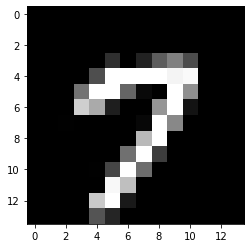

Prediction: Not eight.
5575


In [92]:
N = 50
# pick a random positive input for testing
n = 0
'''
while True:
    n = np.random.choice(list(range(len(X_train))))
    if y_train[n] == 0:
        break
'''
n = 5575

X = X_train[n].reshape(1,SCALE[0],SCALE[1],3).astype(np.float32)
y_hat = np.argmax(bayes_model.predict(X,n=N))
y_class = 'Eight.' if y_hat == 1 else 'Not eight.'
display_number(X,SCALE)
print('Prediction:',y_class)
input_shape = X.flatten().shape
print(n)
ns = [11055,236,5575]

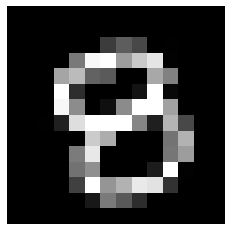

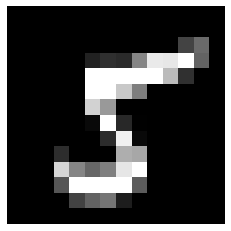

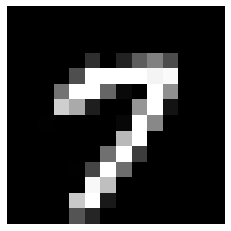

In [64]:
ns = [11055,236,5575]
for n in ns:
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.show()

In [68]:
# GET EXPLS (N MOST CONTRIBUTING)
ns = [11055,236,5575]


sys.path.append("../GTSRB/LayerwiseRelevancePropagation/src")
from lrp import RelevancePropagation
import math

def round_nearest(x, a):
    return round(round(x / a) * a, -int(math.floor(math.log10(a))))

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

ns_exps = []
for n in ns:
    exps = []
    X = X_train[n]
    X = X.reshape(1,SCALE[0],SCALE[1],3)
    for j in range(50):
        bayes_model.set_weights(bayes_model.sample())
        y = np.argmax(np.array(bayes_model._predict(X)).flatten())

        lrp = RelevancePropagation(0.05,'max',True,X.shape,bayes_model.model)
        exp = lrp.run(X.reshape(*X.shape[1:]))
        #plt.imshow(exp,vmin=0,vmax=1)
        #plt.show()

        exp_pop_flat = np.array([i for i in exp.flatten().flatten() if i > 0])
        max_rel = np.max(exp_pop_flat)
        av_rel = np.mean(exp_pop_flat)
        var_rel = np.var(exp_pop_flat)
        #print('Over populated spaces:')
        #print('Max:',max_rel,'Average:',av_rel,'Variance:',var_rel)

        limit = 0.6*max_rel
        #limit = 0
        exp[exp < limit] = 0
        exp[exp > 0] = 1
        #plt.imshow(exp)
        #plt.show()
        exps.append(exp)
    ns_exps.append(exps)


dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)
dense_8
dense_7
dense_6
flat

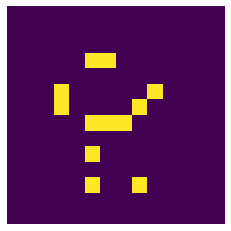

1 2.0


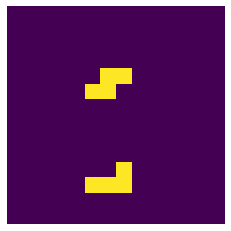

2 4.0


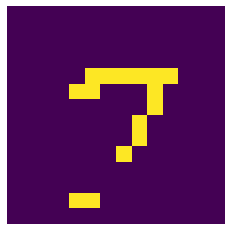

2 4.0


In [69]:
for exps in ns_exps:
    cmap = dict()
    names = []
    es = []
    for e in exps:
        if not str(e) in names:
            names.append(str(e))
            es.append(e)
            cmap[names.index(str(e))] = 0
        cmap[names.index(str(e))] += 1

    res = max(cmap,key=cmap.get)
    res_image = es[res]
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()
    cov = (cmap[res]/50)*100

    print(cmap[res],cov)

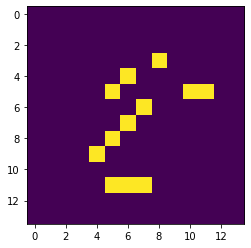

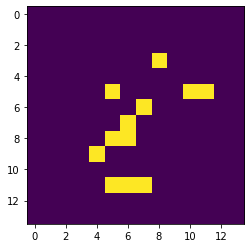

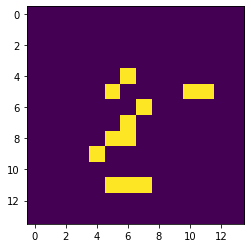

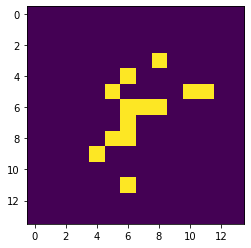

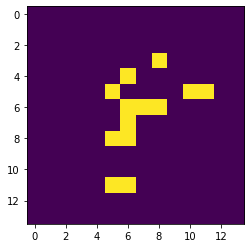

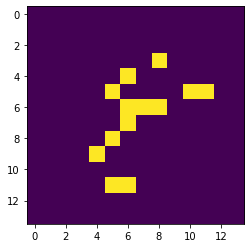

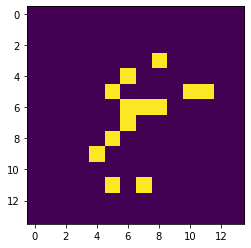

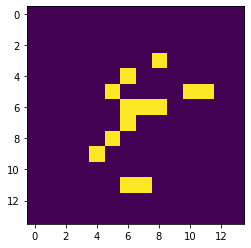

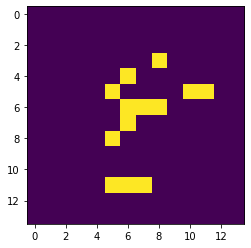

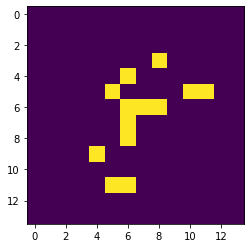

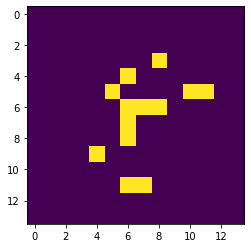

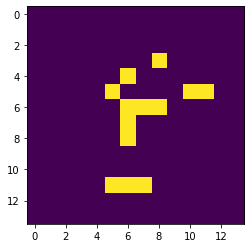

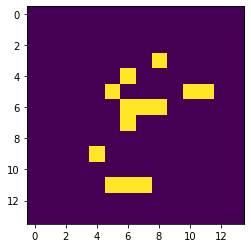

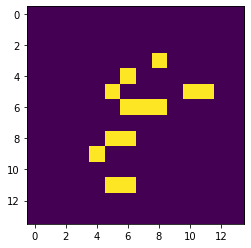

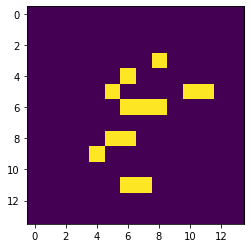

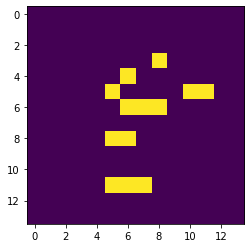

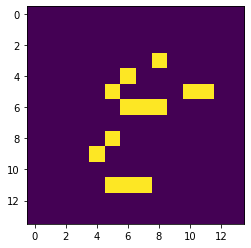

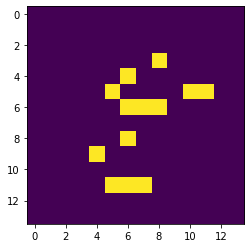

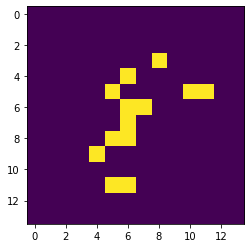

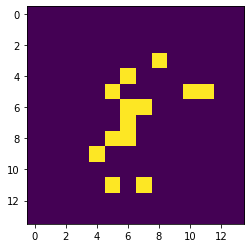

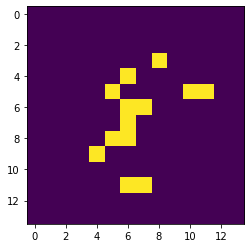

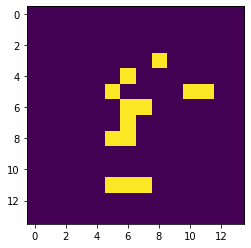

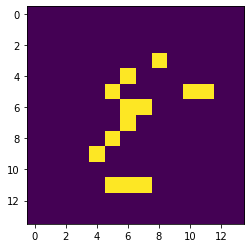

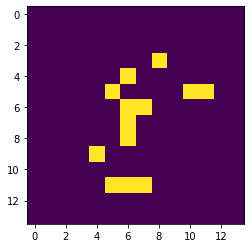

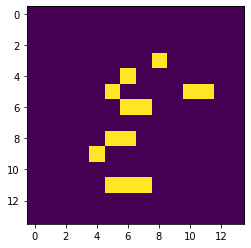

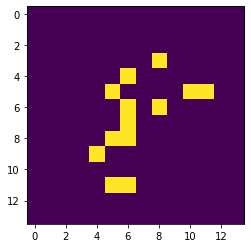

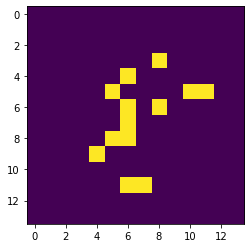

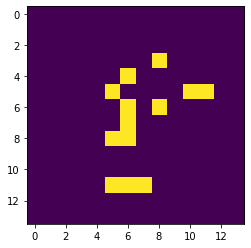

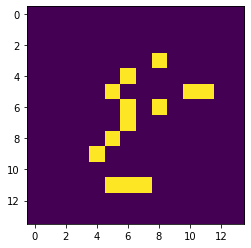

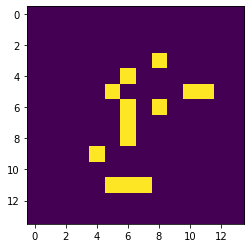

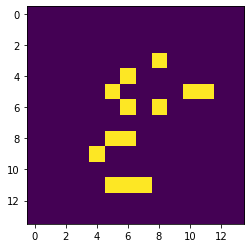

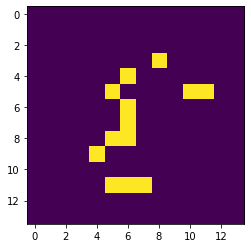

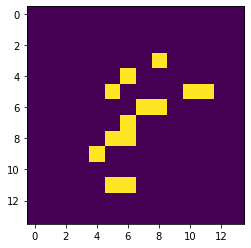

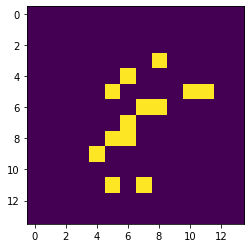

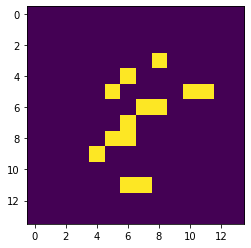

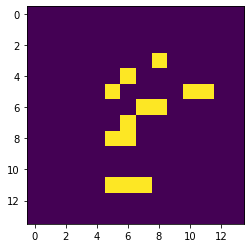

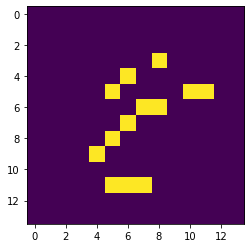

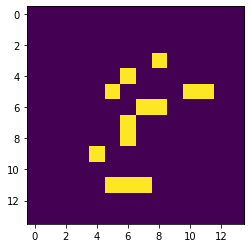

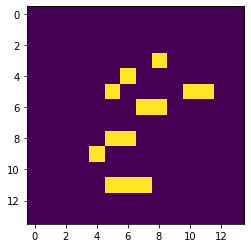

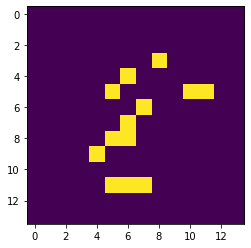

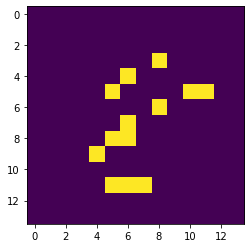

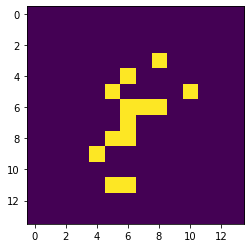

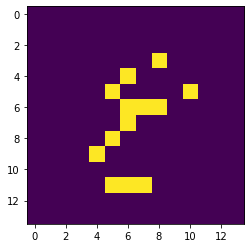

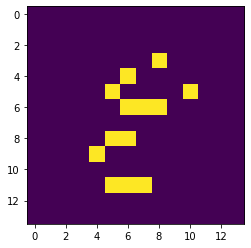

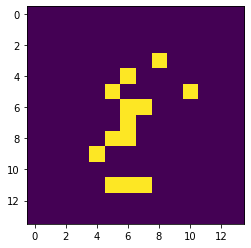

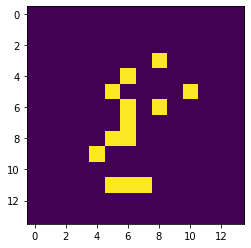

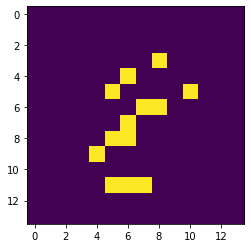

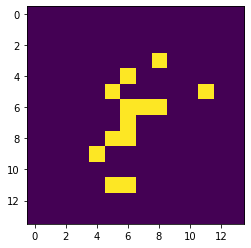

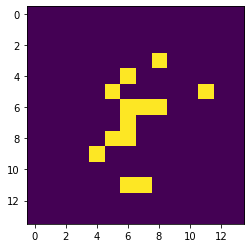

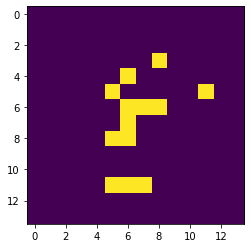

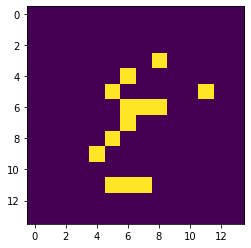

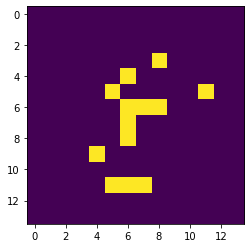

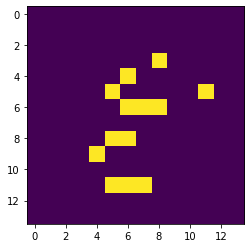

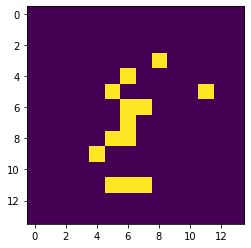

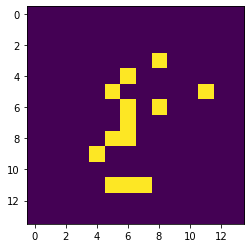

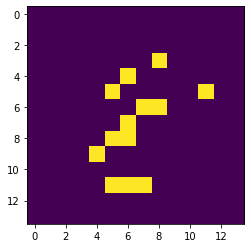

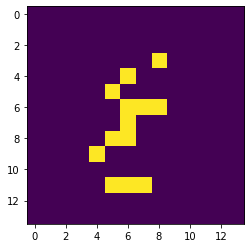

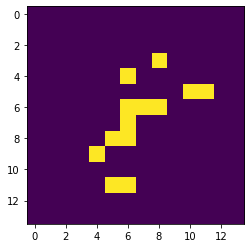

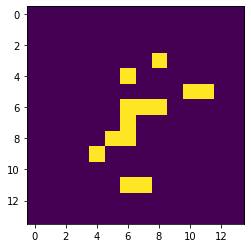

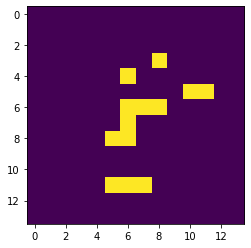

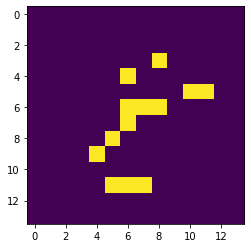

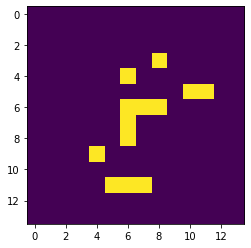

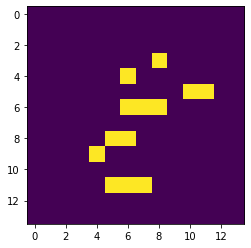

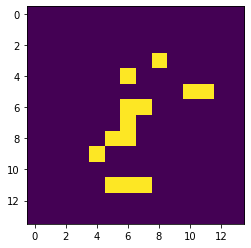

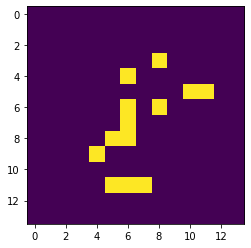

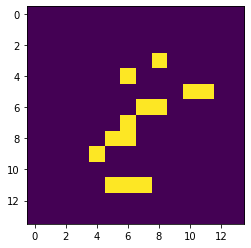

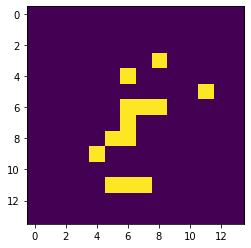

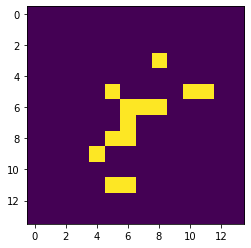

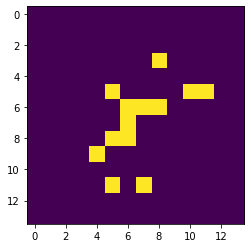

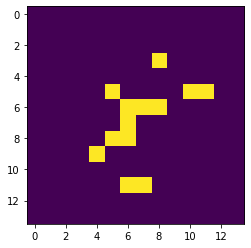

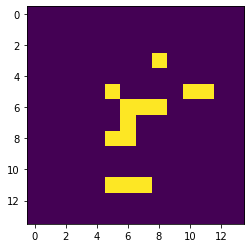

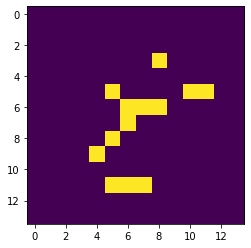

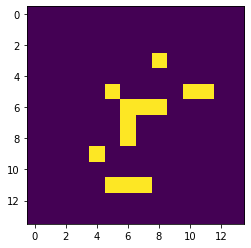

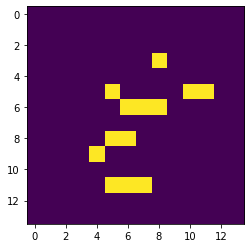

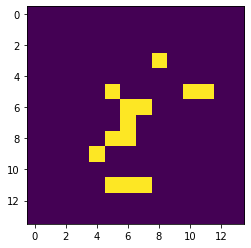

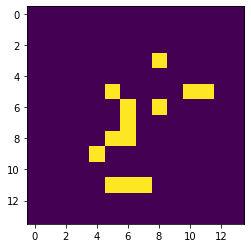

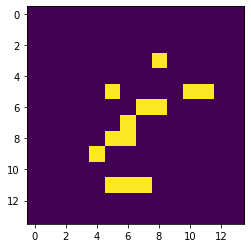

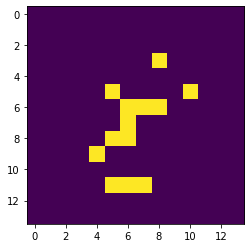

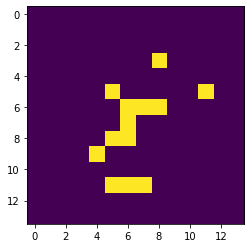

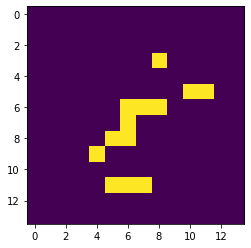

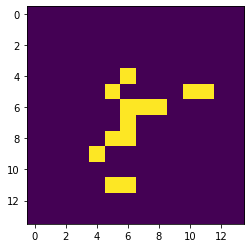

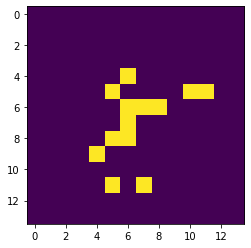

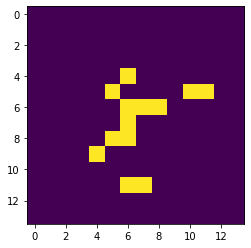

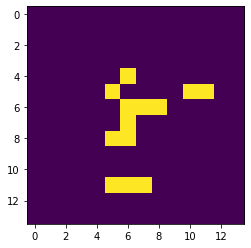

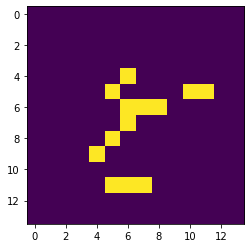

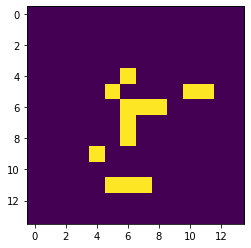

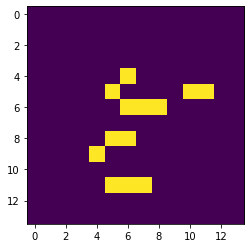

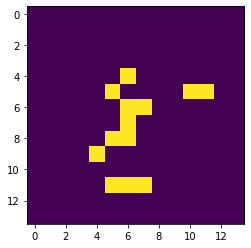

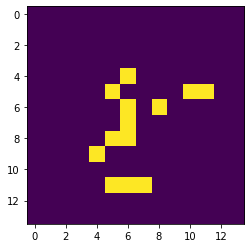

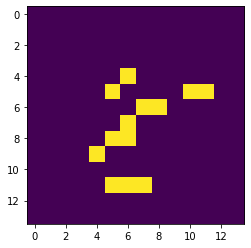

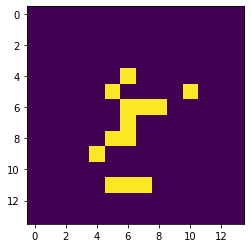

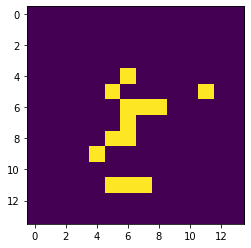

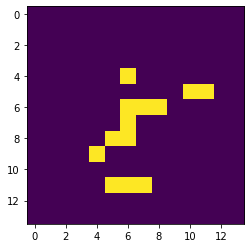

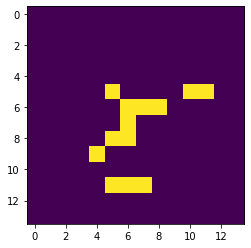

In [9]:
for c in candidates:
    tmp_exp = np.zeros((SCALE[0],SCALE[1]))
    for (y,x) in c:
        tmp_exp[y][x] = 1
    plt.imshow(tmp_exp)
    plt.show()

dense_8
dense_7
dense_6
flatten_2
input_3
(14, 14, 3)


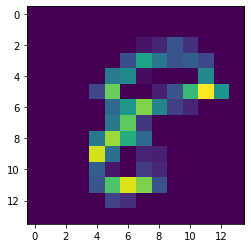

Over populated spaces:
Max: 1.0 Average: 0.3572924425024421 Variance: 0.07597203896310697
0.0


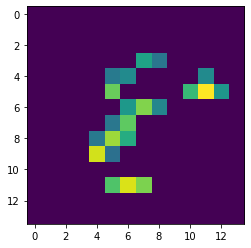

13.899348556821803
150


In [32]:
# GET EXPLS, ARBRITRARY CONTRIBUTING OVER SCORE (bens method)

sys.path.append("../GTSRB/LayerwiseRelevancePropagation/src")
from lrp import RelevancePropagation
import math

def round_nearest(x, a):
    return round(round(x / a) * a, -int(math.floor(math.log10(a))))

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

bayes_model.set_weights(bayes_model.sample())
X = X.reshape(1,SCALE[0],SCALE[1],3)
y = np.argmax(np.array(bayes_model._predict(X)).flatten())

lrp = RelevancePropagation(0.05,'max',True,X.shape,bayes_model.model)
exp = lrp.run(X.reshape(*X.shape[1:]))
plt.imshow(exp,vmin=0,vmax=1)
plt.show()

exp_pop_flat = np.array([i for i in exp.flatten().flatten() if i > 0])
max_rel = np.max(exp_pop_flat)
av_rel = np.mean(exp_pop_flat)
var_rel = np.var(exp_pop_flat)
print('Over populated spaces:')
print('Max:',max_rel,'Average:',av_rel,'Variance:',var_rel)
print(np.min(exp))

limit =0.6*max_rel
exp[exp < limit] = 0
plt.imshow(exp)
plt.show()

from memo import memo

@memo
def generate_min_exps(expl,threshold):
    exps = []
    for i in range(len(expl)):
        orig_expl = expl
        if orig_expl[i] == 0:
            continue
        else:
            if i == len(expl) - 1:
                s = sum(orig_expl[:i])
            else:
                s = sum(orig_expl[:i])+sum(orig_expl[i+1:])
            if s < threshold:
                exps.append(expl)
                break
            else:
                new_expl = tuple(orig_expl[:i]) + (0,)
                if i < len(expl)-1:
                    new_expl = new_expl + tuple(orig_expl[i+1:])
                new_exps = generate_min_exps(new_expl,threshold)
                exps += new_exps
    return exps



print(np.sum(exp))
exp_list = set(generate_min_exps(tuple(exp.flatten()),0.9*np.sum(exp)))
print(len(exp_list))


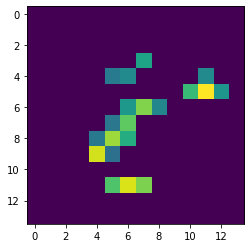

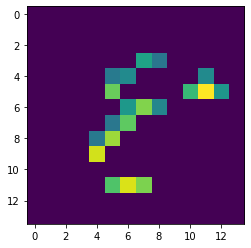

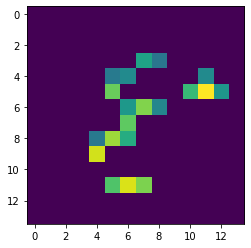

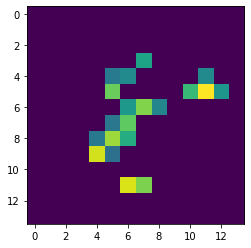

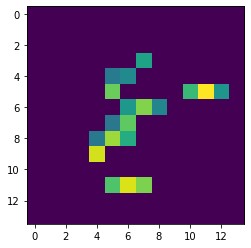

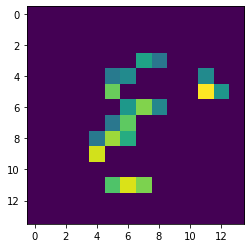

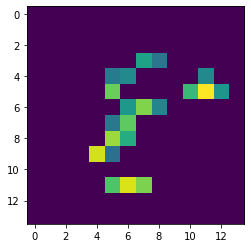

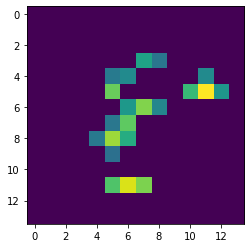

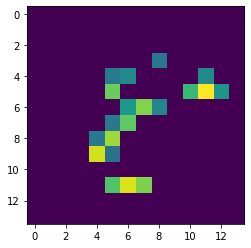

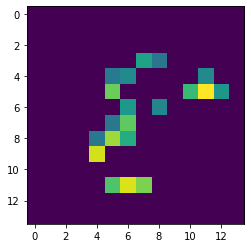

In [33]:
exp_list = list(set(exp_list))
for e in exp_list[:10]:
    e = np.array(e)
    e = e.reshape(SCALE[0],SCALE[1])
    plt.imshow(e)
    plt.show()

In [93]:
input_path = 'X.npy'
y_path = 'y.npy'
output_path = f'exps/exps_ben{n}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),X,False)
np.save(os.path.join(output_path,y_path),y_hat,False)

thresh = 0.88

iterations = 50
for i in range(iterations):
    subprocess.Popen(['python3','get_ben_mnist_exp.py',str(i),model_name,os.path.join(output_path,input_path),output_path, str(SCALE[0]), str(SCALE[1]), str(thresh)])
    
full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) >= iterations+1:
        full = True

0.08695652173913043 46


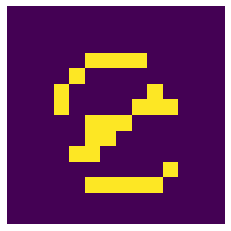

0.04 50


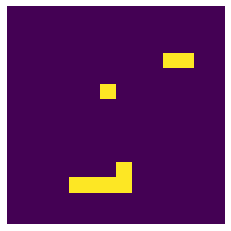

0.18 50


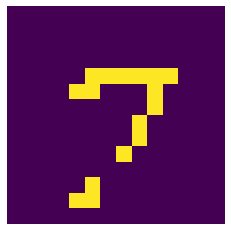

In [95]:
import ast

ns = [11055,236,5575]
preds = [y_train[ns[0]],y_train[ns[1]],y_train[ns[2]]]
for idx,en in enumerate(ns):
    all_exps = []
    path = f'exps/exps_ben{en}'
    for file in os.listdir(path):
        if file[:-4].endswith(f'_{preds[idx]}'):
            e = np.load(os.path.join(path,file),allow_pickle=True)
            all_exps.append(e)
    net_count = len(all_exps)
    #print(net_count)
    coverage_map = dict()
    for exp_list in all_exps:
        exp_list = '['+str(exp_list)[1:-1]+']'
        exp_list = ast.literal_eval(exp_list)
        exp_list = np.array([np.array(inner) for inner in exp_list])
        exp_list[exp_list>0] = 1
        exp_list = [list(inner) for inner in exp_list]
        for exp in exp_list:
            if not str(exp) in coverage_map.keys():
                coverage_map[str(exp)] = 0
            coverage_map[str(exp)] += 1

    cover_exp = max(coverage_map,key=coverage_map.get)
    cover_p = coverage_map[cover_exp]/net_count
    print(cover_p,net_count)
    e = np.array(ast.literal_eval(cover_exp)).reshape(SCALE[0],SCALE[1])
    plt.imshow(e)
    plt.axis('off')
    plt.show()

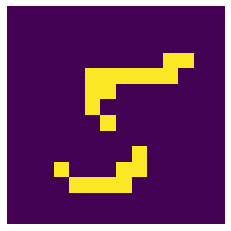

In [78]:
plt.imshow(e)
plt.axis('off')
plt.show()

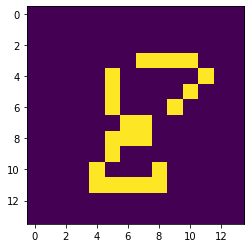

In [91]:
e = np.array(ast.literal_eval(cover_exp)).reshape(SCALE[0],SCALE[1])
plt.imshow(e)
plt.show()

In [1]:
np_exps = np.array(exps)

new_exps = np_exps

merged = sum(new_exps)/len(new_exps)

mexp = merged[0]
pos = np.zeros(input_shape)
neg = np.zeros(input_shape)

clip_val = 100000

if(y_hat == 0):
    pos += np.squeeze(np.clip(mexp, 0, clip_val))
    neg += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
elif(y_hat == 1):
    neg += np.squeeze(np.clip(mexp, 0, clip_val))
    pos += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
    
display_number(X.flatten(),SCALE)
expl = pos if y_hat == 0 else neg
display_explanation(X.flatten(),SCALE,expl)

NameError: name 'np' is not defined

In [8]:
uncert_Xs = []
uncert_Ypredarrs = []
uncert_ytruth = []
for idx,xt in enumerate(X_test):
    if idx%100 == 0:
        print('step',idx)
    s_len = len(uncert_Xs)
    Xt_one = np.array([xt])
    y_preds = []
    n = 50
    truth = y_test[idx]
    for i in range(n):
        bayes_model.model.set_weights(bayes_model.sample())
        y_preds.append(bayes_model.model(Xt_one))

    #print(y_preds)
    argmax = list(map(np.argmax,y_preds))
    try:
        m = mode(argmax)
        if not argmax.count(m) >= len(argmax)-(n/2):
            uncert_Xs.append(list(map(float,xt)))
            uncert_Ypredarrs.append([list(map(float,yp[0])) for yp in y_preds])
            uncert_ytruth.append(int(truth))
    except:
        uncert_Xs.append(list(map(float,xt)))
        uncert_Ypredarrs.append([list(map(float,yp[0])) for yp in y_preds])
        uncert_ytruth.append(int(truth))

    if len(uncert_Xs) > s_len:
        print(len(uncert_Xs))
    if len(uncert_Xs) > 4:
        break
        
to_file_entries = []
for idx,uyp in enumerate(uncert_Ypredarrs):
    entry = dict()
    entry['input'] = uncert_Xs[idx]
    entry['y'] = uncert_ytruth[idx]
    entry['y_pred_arrs'] = uyp
    entry['y_preds'] = list(map(int,list(map(np.argmax,uyp))))
    to_file_entries.append(entry)
    print(list(map(np.argmax,uyp)))

# save uncert inputs to file

with open('uncert_data/uncert_mnist.json','w') as f:
    json.dump(to_file_entries,f)
    

step 0
step 100
step 200
step 300


KeyboardInterrupt: 

In [102]:
# TAKES A WHILE TO RUN (~5 MINS)

uncert_idx = 3

uncert_dict = None
with open('uncert_data/uncert_mnist.json','r') as f:
    uncert_dict = json.load(f)
    
if uncert_idx > len(uncert_dict):
    print('No data at this index.')
    
uncert_X = np.asarray(uncert_dict[uncert_idx]['input']).reshape(1,SCALE[0]*SCALE[1]).astype(float)
uncert_y = uncert_dict[uncert_idx]['y']

input_path = 'X_uncert.npy'
y_path = 'y_uncert.npy'
output_path = f'exps/exps_uncert{uncert_idx}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),uncert_X,False)
np.save(os.path.join(output_path,y_path),uncert_y,False)

iterations = 20
for i in range(iterations):
    subprocess.Popen(['python3','get_mnist_exp.py',str(i),model_name,os.path.join(output_path,input_path),output_path])
    
full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) == iterations+1:
        full = True
    

Input image (ground truth = 0 Negative (it's not an 8)):


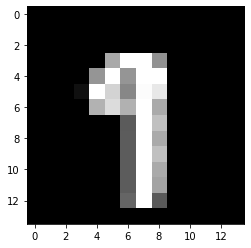

Positive explanation (contributes to class 0):


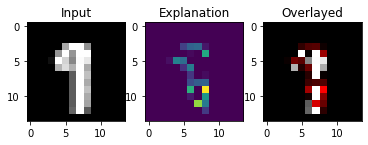

Negative explanation (contributes against class 0):


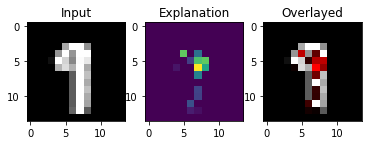


Sanity checking
---------------
Index in X_test: 1554
Classification in y_test: 0


In [11]:
# read in and display the results from an uncert input

input_num = 1
input_path = 'X_uncert.npy'
output_path = f'exps/exps_uncert{input_num}'
y_path = 'y_uncert.npy'


exps = []
for f in os.listdir(output_path):
    if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y'):
        tmp = np.load(os.path.join(output_path,f))
        exps.append(tmp)
        
uncert_X = np.load(os.path.join(output_path,input_path))
uncert_y = np.load(os.path.join(output_path,y_path))

input_shape = uncert_X.flatten().shape
        
np_exps = np.array(exps)

new_exps = np_exps

merged = sum(new_exps)/len(new_exps)

mexp = merged[0]
pos = np.zeros(input_shape)
neg = np.zeros(input_shape)

clip_val = 100000

if(uncert_y == 0):
    pos += np.squeeze(np.clip(mexp, 0, clip_val))
    neg += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
elif(uncert_y == 1):
    neg += np.squeeze(np.clip(mexp, 0, clip_val))
    pos += -1*np.squeeze(np.clip(mexp, -clip_val, 0))

act_class = "Positive (it's an 8)" if uncert_y > 0 else "Negative (it's not an 8)" 
print(f'Input image (ground truth = {uncert_y} {act_class}):')
display_number(uncert_X.flatten(),SCALE)
print(f'Positive explanation (contributes to class {uncert_y}):')
display_explanation(uncert_X.flatten(),SCALE,pos)
print(f'Negative explanation (contributes against class {uncert_y}):')
display_explanation(uncert_X.flatten(),SCALE,neg)
print()
print('Sanity checking')
print('---------------')
for idx,xt in enumerate(X_test):
    if list(uncert_X.flatten()) == list(map(float,xt)):
        print('Index in X_test:',idx)
        print('Classification in y_test:',y_test[idx])

In [ ]:
# want to find: average bayesian explanation of an 8

# train on just 1's and 9's, give it a 7 (look at prediction for both 1 and 9, hope we see corresponding parts)

# pick another good explanation method